In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [3]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df.fillna(0, inplace=True)
df['median_house_value'] = np.log1p(df['median_house_value'].values)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del X_train['median_house_value']
del X_val['median_house_value']
del X_test['median_house_value']

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

## Question 1

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

important_split_feature = dv.feature_names_[np.argmax(dt.feature_importances_)]
print(f"Most important split feature: {important_split_feature}")

Most important split feature: ocean_proximity=<1H OCEAN


In [7]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

In [8]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on validation data :{rmse}")

RMSE on validation data :0.24527740463893763


## Question 3

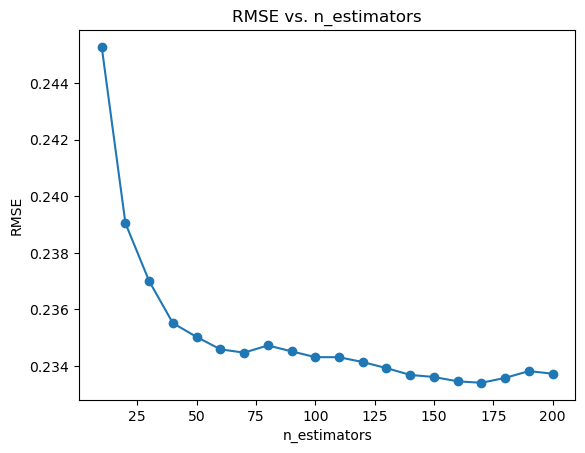

The best value of n_estimator: 170


In [12]:
n_estimators_values = list(range(10, 201+1, 10))
rmse_values = []

for n in n_estimators_values:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    
plt.plot(n_estimators_values, rmse_values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. n_estimators')
plt.show()

minim_rmse = min(rmse_values)
minim_rmse_index = rmse_values.index(minim_rmse)
best_n_estimators = n_estimators_values[minim_rmse_index]

print(f"The best value of n_estimator: {best_n_estimators}")

##  Question 4

In [13]:
max_depth_values = [10, 15, 20, 25]
estimators_values = list(range(10, 201+1, 10))

best_rmse = float('inf') #
best_max_depth = None

for depth in max_depth_values:
    for n in estimators_values:
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_depth = depth

print(f"The best max_depth is: {best_max_depth}")

The best max_depth is: 25


## Question 5

In [14]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, df_train['median_house_value'])

importances = rf.feature_importances_

most_important_index = np.argmax(importances)
most_important_feature = dv.feature_names_[most_important_index]

print(f"The most important feature is: {most_important_feature}")

The most important feature is: median_income


## Question 6

In [19]:


features = dv.get_feature_names_out()
features= [i.replace("=<", "_").replace("=","_") for i in features]


dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


watchlist = [(dtrain, 'train'), (dval, 'val')]


xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model_03 = xgb.train(xgb_params_03, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)
y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(df_val['median_house_value'], y_pred_03))


xgb_params_01 = xgb_params_03.copy()
xgb_params_01['eta'] = 0.1
model_01 = xgb.train(xgb_params_01, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)
y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(df_val['median_house_value'], y_pred_01))

print(f"RMSE for eta=0.3: {round(rmse_03, 3)}")
print(f"RMSE for eta=0.1: {round(rmse_01, 3)}")

RMSE for eta=0.3: 0.229
RMSE for eta=0.1: 0.232
